In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import random
import cv2

from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import Visualizer
from pathlib import Path
from MLtools import plotting

In [2]:
def get_boulder_dicts(json_file, img_dir, dataset_type):
    df = pd.read_json(json_file)
    df_copy = df.copy()
    df_copy["file_name"] = img_dir / df.dataset / "images" / df.file_name
    df_copy["file_name"] = df_copy["file_name"].astype(str)
    df_dataset= df_copy[df_copy.dataset == dataset_type]
    df_dataset = df_dataset.drop(columns=["dataset"])
    return (df_dataset.to_dict(orient="records"))


def generate_custom_dataset(json_file, img_dir, dataset_name):

    for d in ["train", "validation", "test"]:
        DatasetCatalog.register(dataset_name + "_" + d, lambda d=d: get_boulder_dicts(json_file, img_dir, d))
        MetadataCatalog.get(dataset_name + "_" + d).set(thing_classes=["boulder"])
    boulder_metadata = MetadataCatalog.get(dataset_name + "_train")

    return boulder_metadata

# this can be run if you have downloaded the input data in DOWNLOAD_DATA_BOULDERING.ipynb
home_p = Path.home()
json_file = home_p / "tmp" / "BOULDERING" / "preprocessed_inputs" / "json" / "Apr2023-Mars-Moon-Earth-mask-5px.json"
img_dir = home_p / "tmp" / "BOULDERING" / "preprocessed_inputs" / "preprocessing"
dataset_name = "boulder_bitmask_5px"
boulder_metadata = generate_custom_dataset(json_file, img_dir, dataset_name)

In [3]:
boulder_metadata

namespace(name='boulder_bitmask_5px_train', thing_classes=['boulder'])

## Looking at images (with corresponding labels) in the training dataset

In [4]:
dataset_dicts = get_boulder_dicts(json_file, img_dir, "train")

/home/nilscp/tmp/BOULDERING/preprocessed_inputs/preprocessing/train/images/ESP_037018_2170_RED_MRDR_0866_image.png
/home/nilscp/tmp/BOULDERING/preprocessed_inputs/preprocessing/train/images/M139694087LE_0990_image.png
/home/nilscp/tmp/BOULDERING/preprocessed_inputs/preprocessing/train/images/courtright-reservoir-sept2022-morning_0242_image.png
/home/nilscp/tmp/BOULDERING/preprocessed_inputs/preprocessing/train/images/courtright-reservoir-sept2022-morning_0247_image.png
/home/nilscp/tmp/BOULDERING/preprocessed_inputs/preprocessing/train/images/M1221383405_2504_image.png
/home/nilscp/tmp/BOULDERING/preprocessed_inputs/preprocessing/train/images/M139694087LE_0584_image.png
/home/nilscp/tmp/BOULDERING/preprocessed_inputs/preprocessing/train/images/M139694087LE_0902_image.png
/home/nilscp/tmp/BOULDERING/preprocessed_inputs/preprocessing/train/images/M139694087LE_1118_image.png
/home/nilscp/tmp/BOULDERING/preprocessed_inputs/preprocessing/train/images/courtright-reservoir-sept2022-morning_02

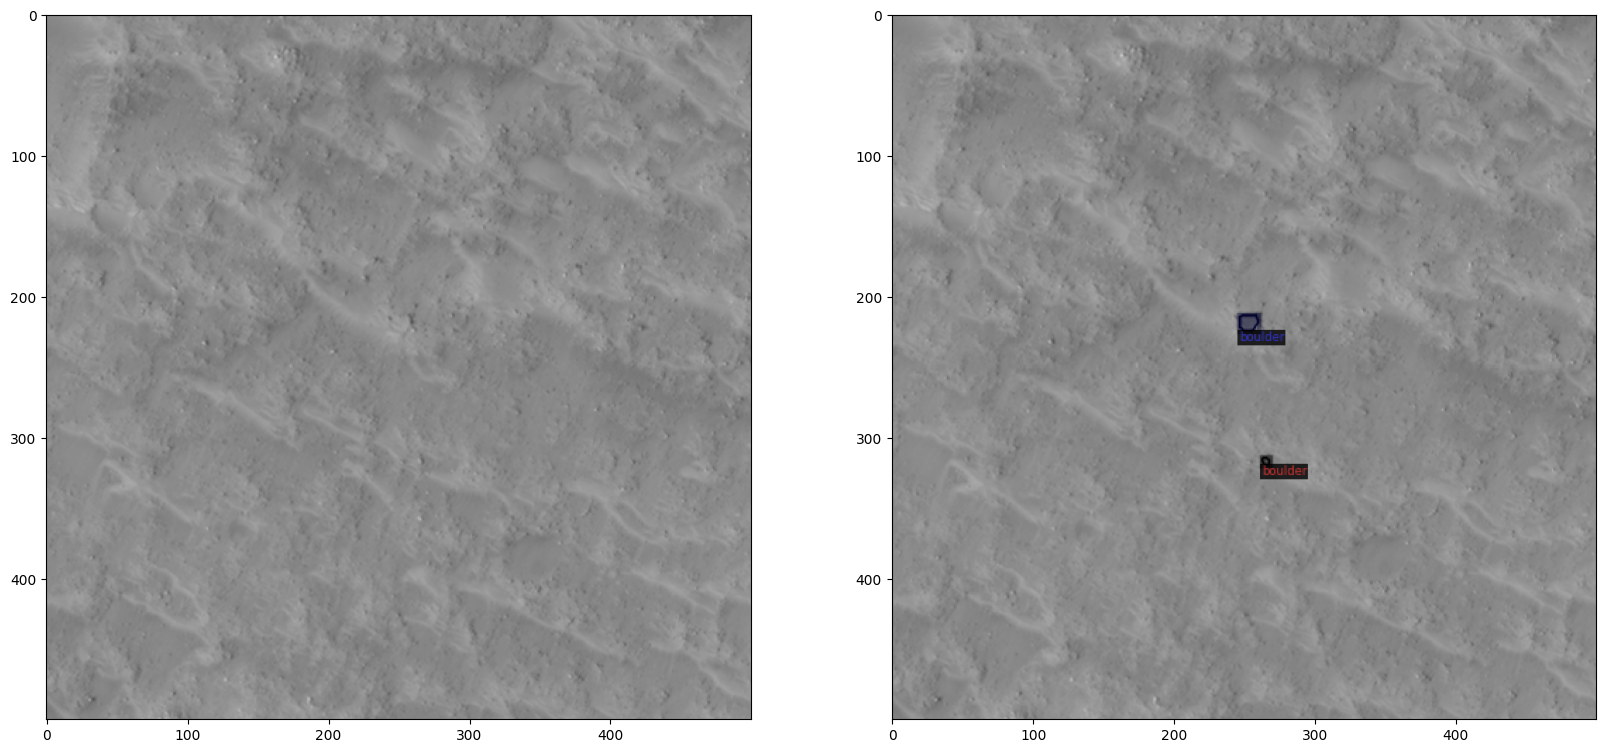

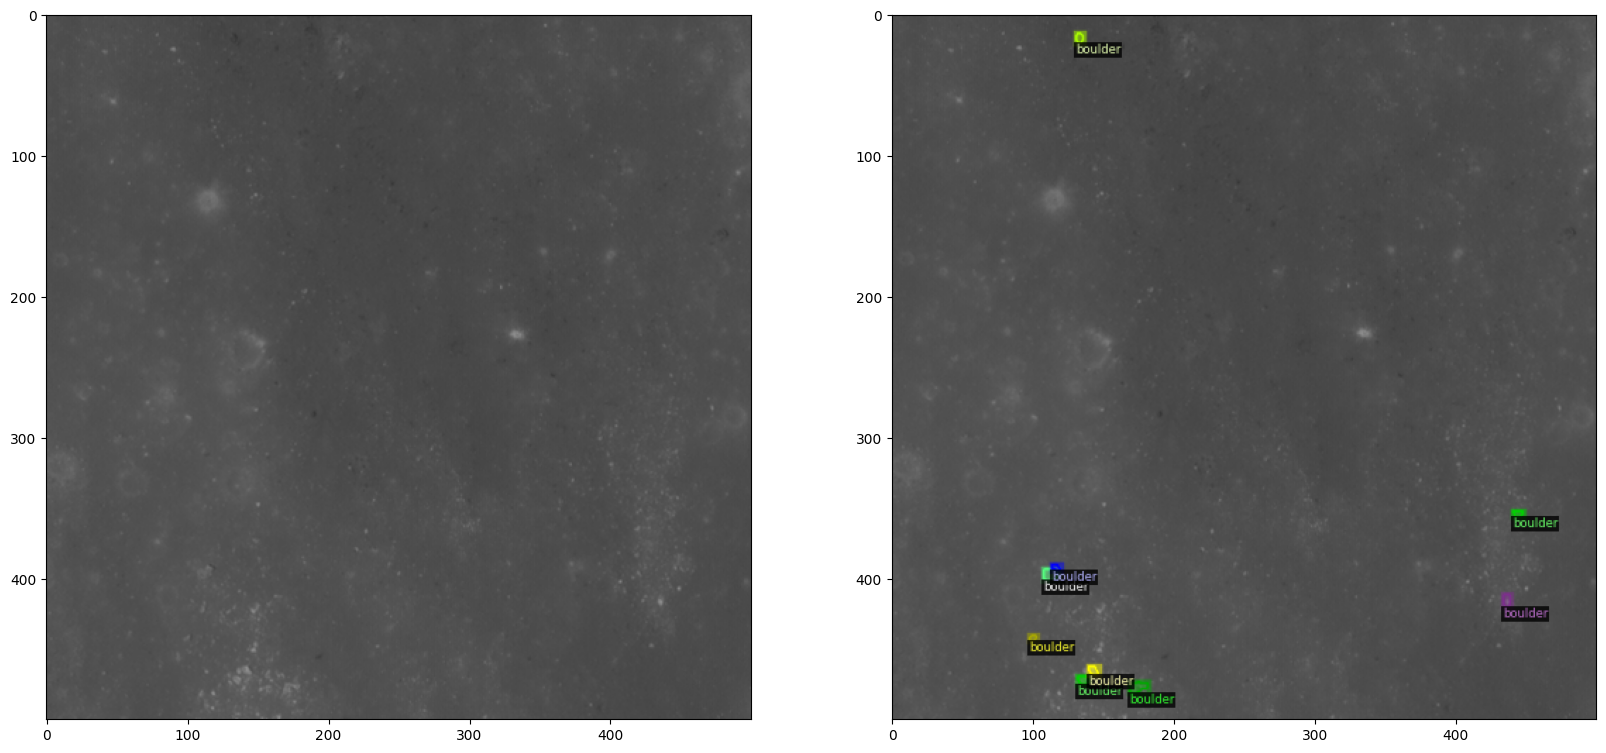

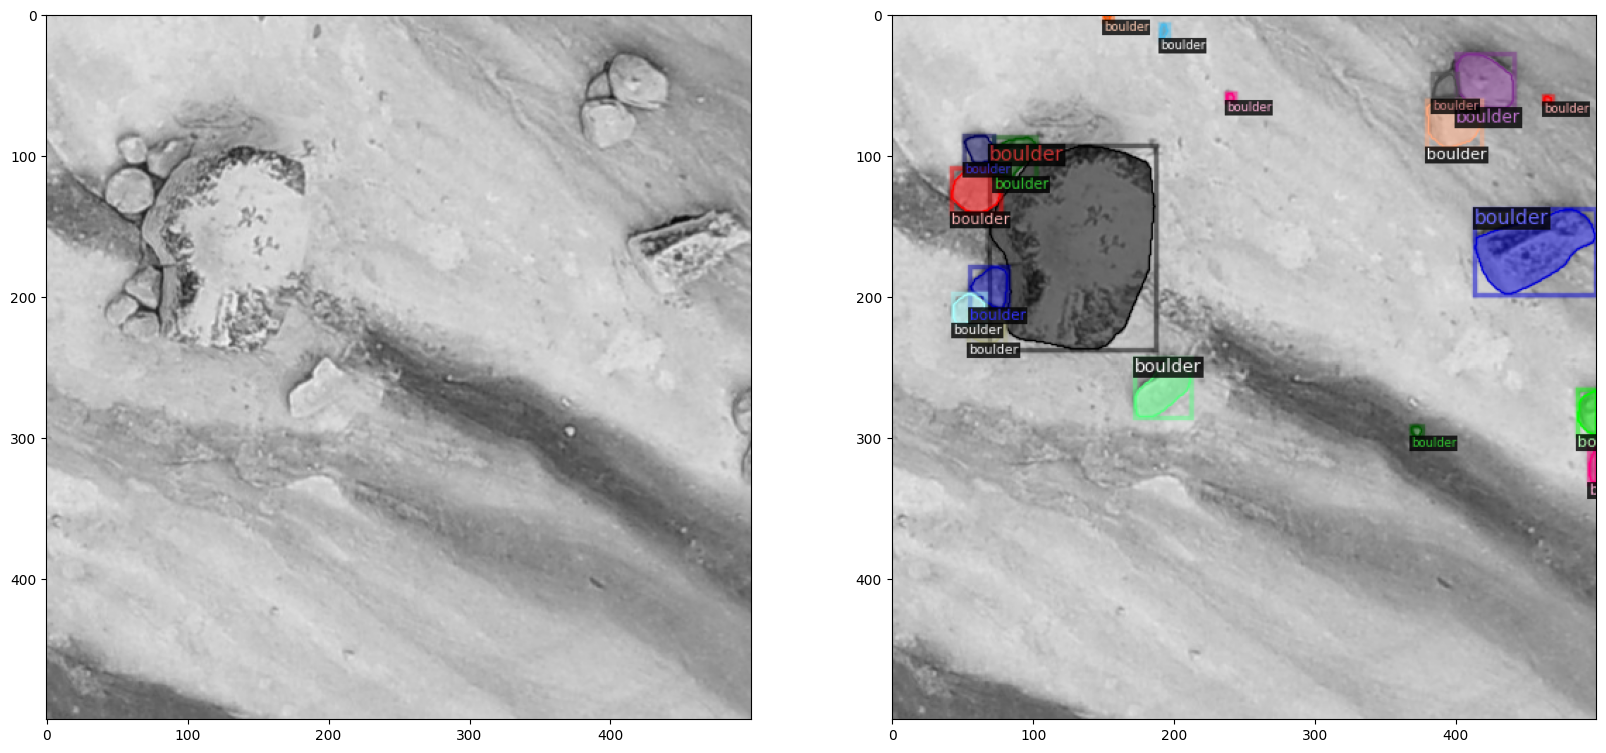

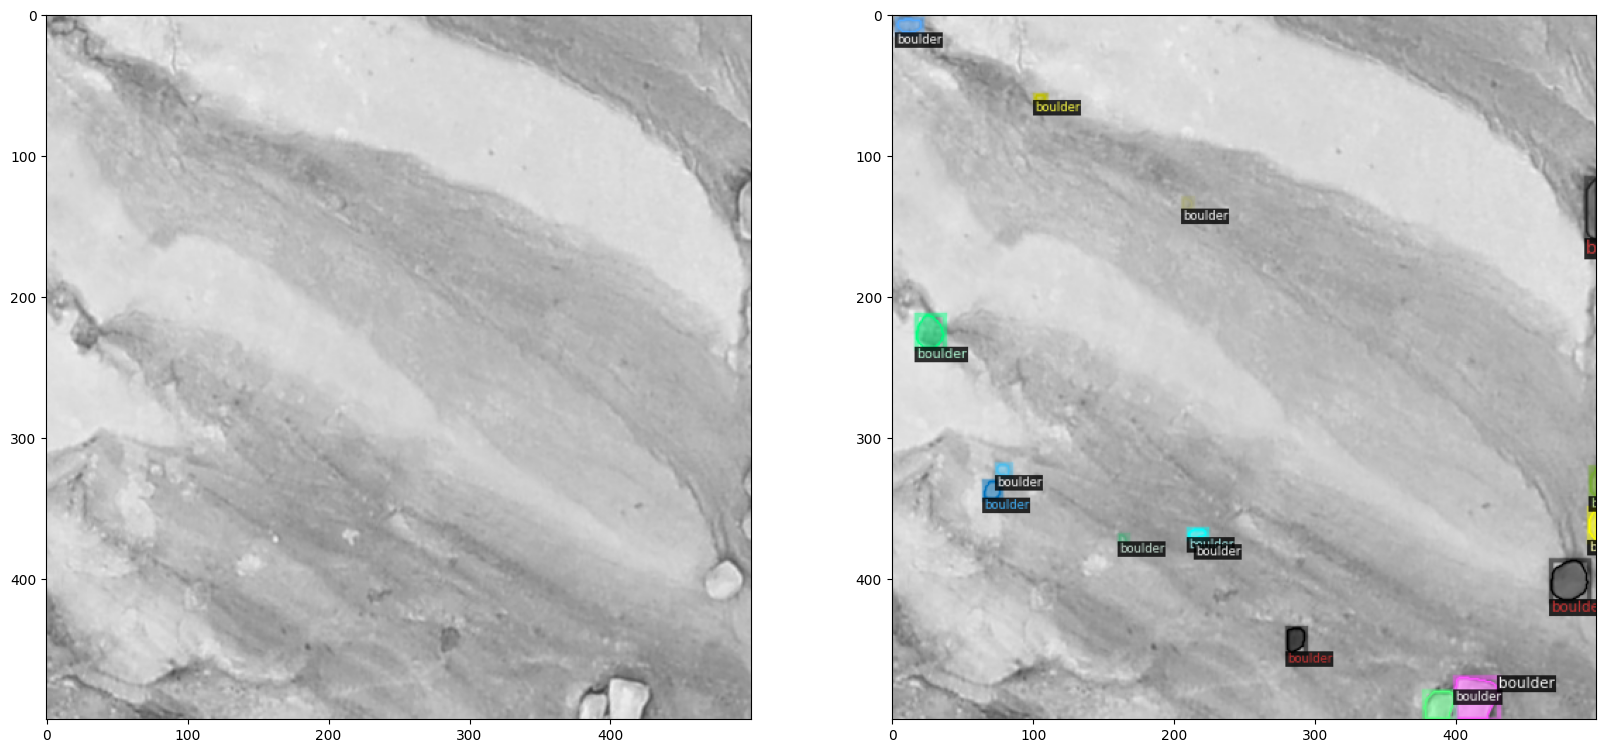

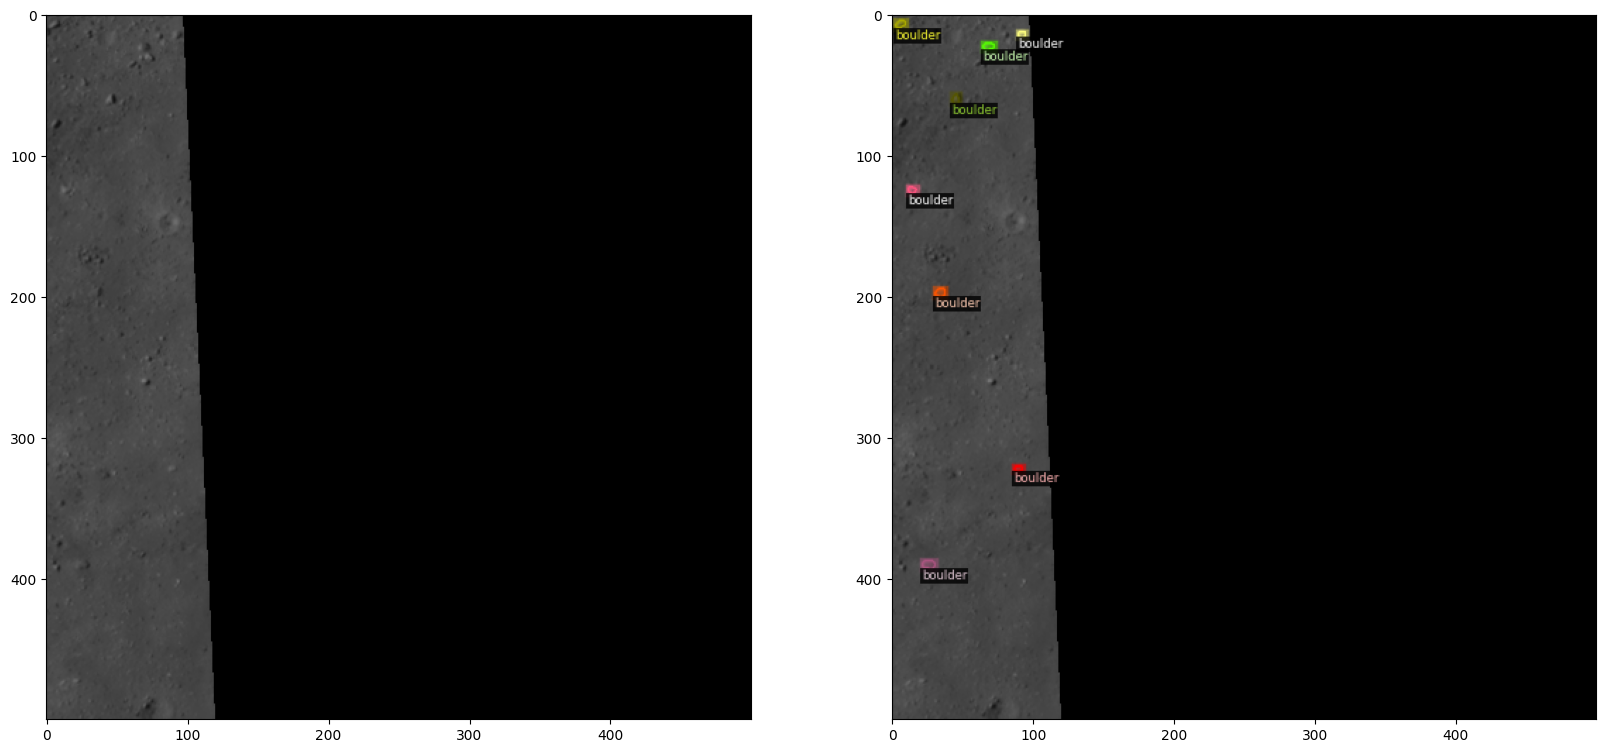

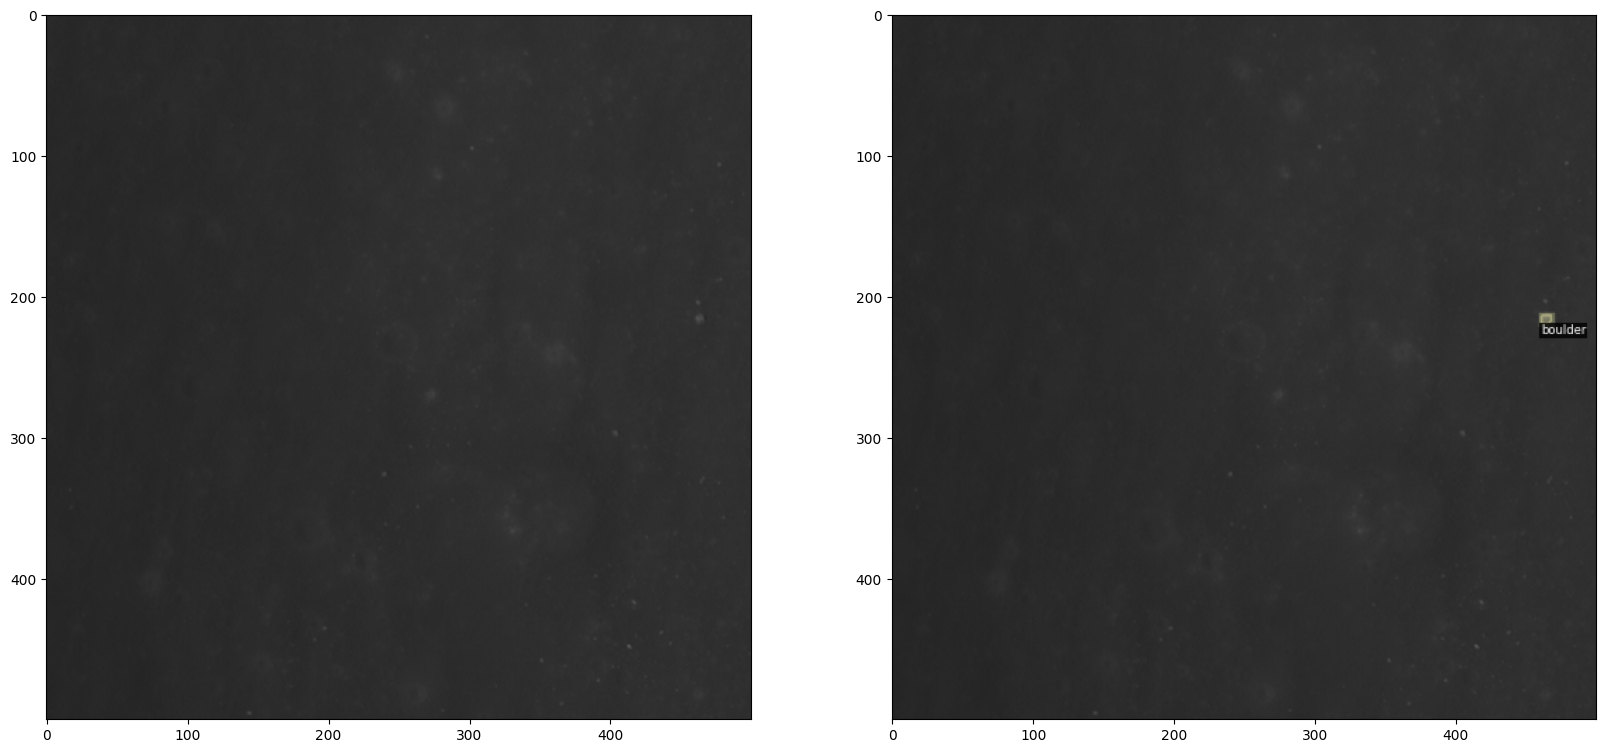

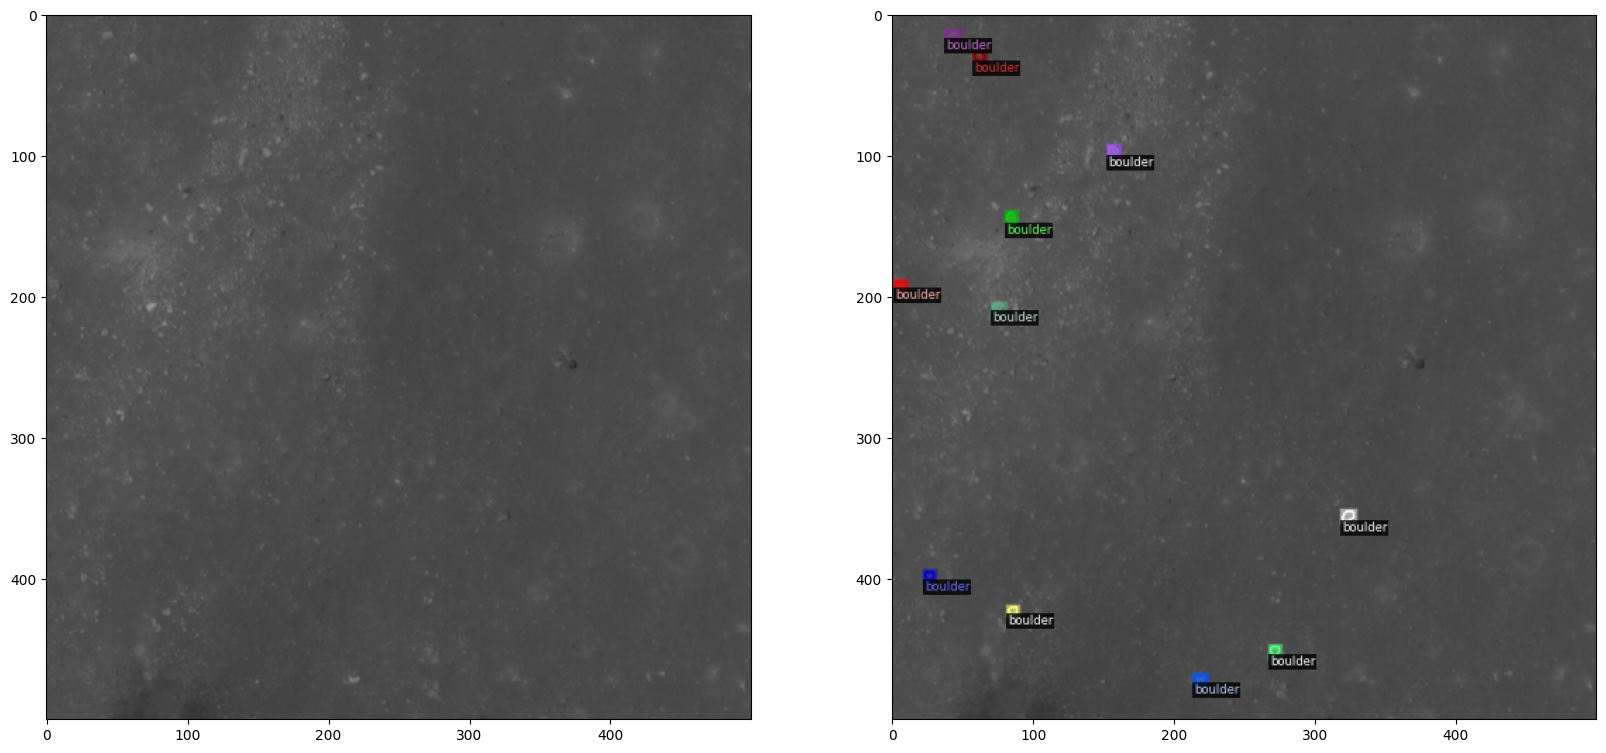

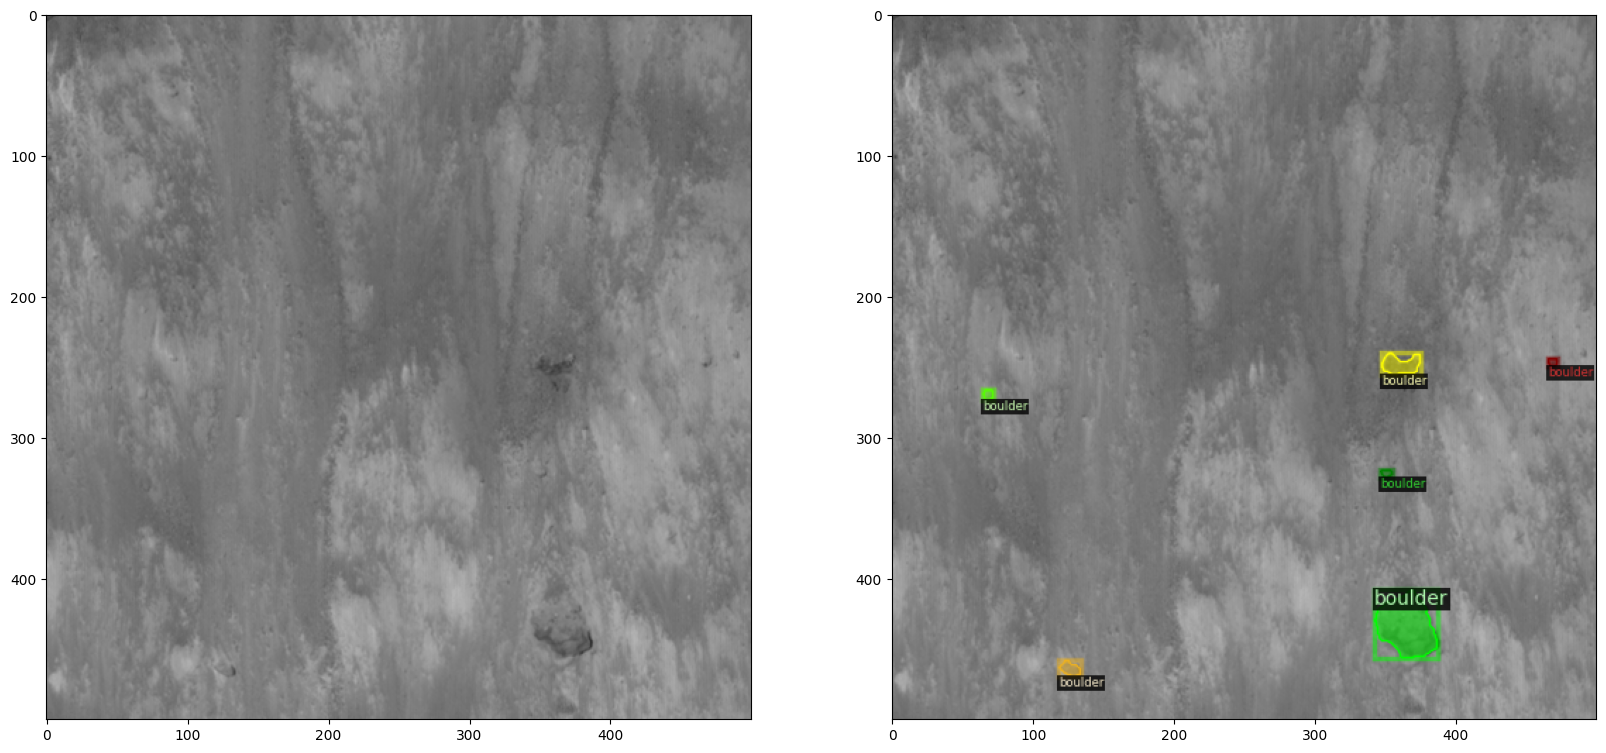

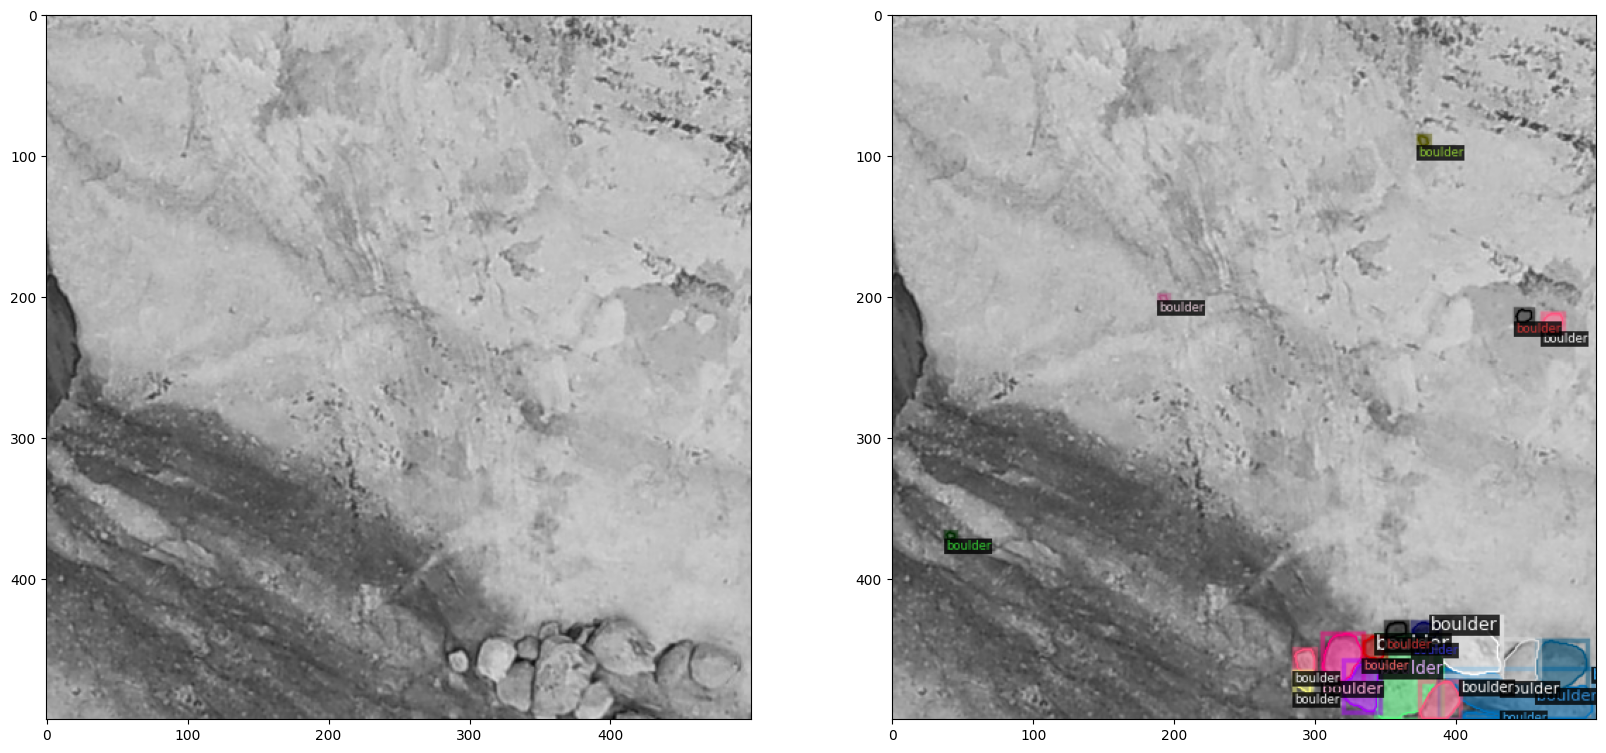

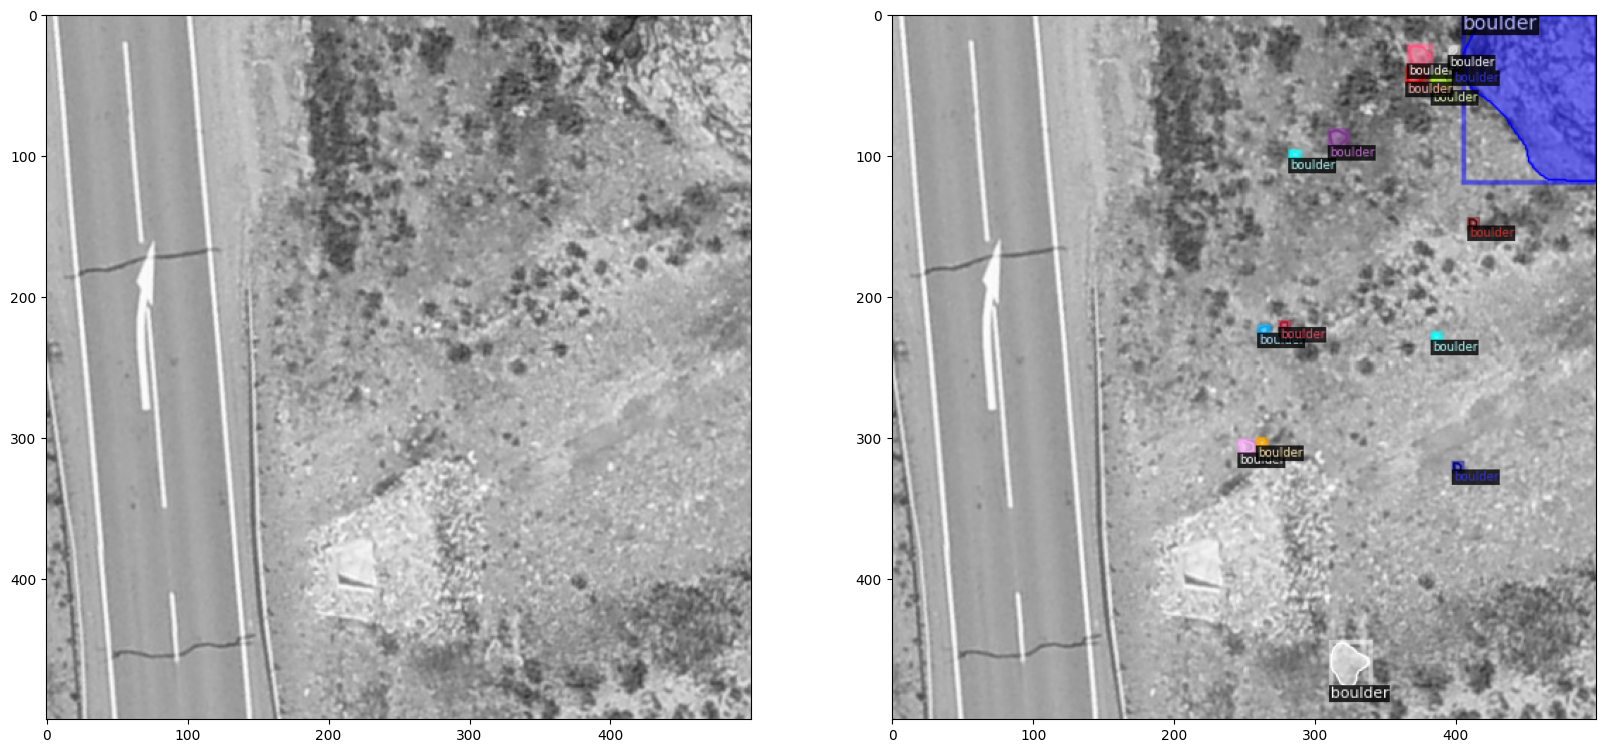

In [12]:
for d in random.sample(dataset_dicts, 10):
    print(d["file_name"])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=boulder_metadata, scale=1.0)
    out = visualizer.draw_dataset_dict(d)
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,10))
    mp = plotting.cv2_imshow(out.get_image()[:, :, ::-1])
    ax = ax.ravel()
    ax[0].imshow(img)
    ax[1].imshow(mp)

In [12]:
d["file_name"]

'~/tmp/BOULDERING/preprocessed_inputs/preprocessing/train/images/M1113133069_1419_image.png'

## Same as above, but including the augmentation pipeline

In [23]:
import sys
sys.path.append("/home/nilscp/GIT/") # change accordingly
sys.path.append("/home/nilscp/GIT/astroNils/MLtools/projects/bouldering/") # change accordingly
sys.path.append("/home/nilscp/GIT/astroNils/MLtools/projects/bouldering/bouldering") # change accordingly

from config import add_config
from detectron2.engine import default_setup
from detectron2.config import get_cfg

def setup(cfg, aug_path, min_area_npixels, optimizer_name, scheduler_mode):
    """
    Create configs and perform basic setups.
    """

    use_cuda = torch.cuda.is_available()
    if use_cuda:
        print('__CUDNN VERSION:', torch.backends.cudnn.version())
        print('__Number CUDA Devices:', torch.cuda.device_count())
        print('__CUDA Device Name:', torch.cuda.get_device_name(0))
        print('__CUDA Device Total Memory [GB]:',
              torch.cuda.get_device_properties(0).total_memory / 1e9)

    device = "cuda" if use_cuda else "cpu"
    print("Device: ", device)

    cfg = get_cfg()
    add_config(cfg, aug_path, min_area_npixels, optimizer_name, scheduler_mode)
    cfg.merge_from_file(args.config_file)
    cfg.merge_from_list(args.opts)
    cfg.MODEL.DEVICE = device
    default_setup(cfg, args)
    return cfg

In [24]:
from train_net import MyTrainer

In [ ]:
aug_path = home_p / "tmp" / "BOULDERING" / "best_model" / "augmentation_setup.json"
cfg = home_p / "tmp" / "BOULDERING" / "best_model" / "augmentation_setup.json"
aug_path = aug_path.as_posix()
min_area_npixels = 0
optimizer_name = "SGD"
scheduler_mode = "triangular2"

cfg_with_aug = setup(cfg, aug_path, min_area_npixels, optimizer_name, scheduler_mode)